In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyfolio as pf
import warnings
warnings.simplefilter('ignore')

### Aggressive Bold Asset Allocation Strategy

This strategy employs an asset allocation approach that dynamically shifts between offensive and defensive assets based on momentum indicators. The methodology leverages the 13612W momentum for asset selection and relative momentum for portfolio weight determination.

#### 1. Asset Universes

- **Canary Universe:** $A_{\text{canary}} = \{\text{SPY}, \text{EFA}, \text{EEM}, \text{AGG}\}$
- **Offensive Universe (Aggressive):** $A_{\text{offensive}} = \{\text{QQQ}, \text{EEM}, \text{EFA}, \text{AGG}\}$
- **Defensive Universe:** $A_{\text{defensive}} = \{\text{TIP}, \text{DBC}, \text{BIL}, \text{IEF}, \text{TLT}, \text{LQD}, \text{AGG}\}$

#### 2. Calculation of 13612W Momentum

Define 13612W momentum as a weighted sum of 1, 3, 6, and 12-month returns:

$
\text{Momentum}_{13612W,i,t} = 12 \times \left(\frac{P_{i,t}}{P_{i,t-1}} - 1\right) + 4 \times \left(\frac{P_{i,t}}{P_{i,t-3}} - 1\right) + 2 \times \left(\frac{P_{i,t}}{P_{i,t-6}} - 1\right) + \left(\frac{P_{i,t}}{P_{i,t-12}} - 1\right)
$

where $P_{i,t}$ is the price of asset $i$ at time $t$.

#### 3. Calculation of Relative Momentum

Relative momentum for asset $i$ is calculated as:

$
\text{Relative Momentum}_{i,t} = \frac{P_{i,t}}{\text{SMA}_{13,i,t}}
$

where $\text{SMA}_{13,i,t}$ is the 13-month simple moving average of the price of asset $i$.

#### 4. Allocation Strategy

- **Monthly Rebalancing:** Allocate at the end of each month.
- **Momentum Evaluation:** Evaluate momentum for the canary universe to determine the asset allocation universe (offensive or defensive).

##### Allocation Rules:

1. **Canary Universe Evaluation:**
   - Compute the 13612W momentum for the canary universe.
   - If all canary assets have positive momentum:
     - Select the offensive universe.
     - Allocate 100% to the asset with the highest relative momentum within the offensive universe.
   - If not all canary assets have positive momentum:
     - Select the defensive universe.
     - Identify the top 3 assets with the highest relative momentum within the defensive universe.
     - Allocate weights evenly among these top 3 assets, ensuring each allocation is compared with BIL (cash equivalent), and allocate to BIL if it has a higher relative momentum.


#### Summary

The Aggressive Bold Asset Allocation strategy leverages a dual momentum approach, combining the 13612W momentum and relative momentum to dynamically allocate assets between offensive and defensive universes. By evaluating the performance of canary assets, the strategy aims to optimize returns while mitigating risks through conditional asset selection and allocation rules.


[*********************100%%**********************]  12 of 12 completed


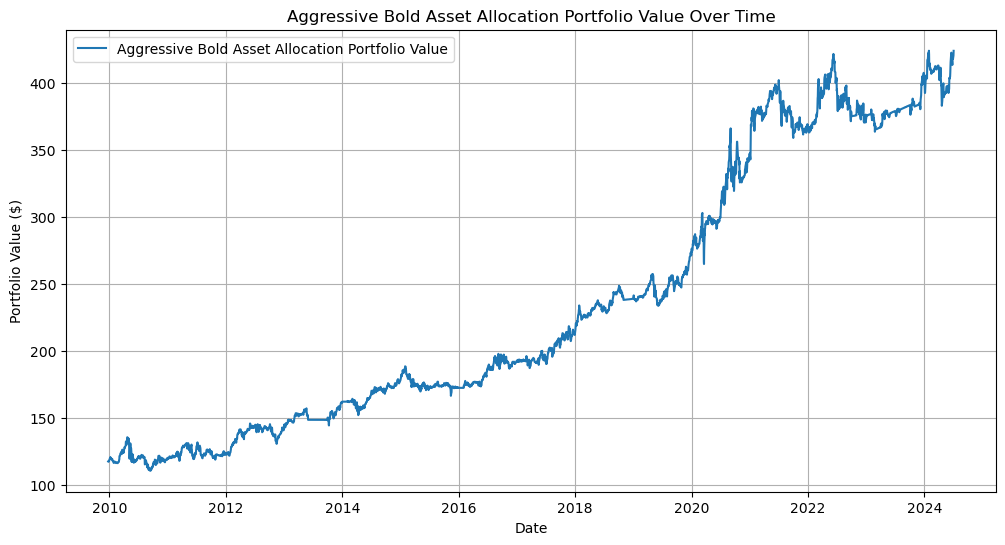

In [12]:
# Define the asset universes
canary_universe = ['SPY', 'EFA', 'EEM', 'AGG']
offensive_universe_aggressive = ['QQQ', 'EEM', 'EFA', 'AGG', "SPY", "IWM"]
defensive_universe = ['TIP', 'DBC', 'BIL', 'IEF', 'TLT', 'LQD', 'AGG']

# Download the historical data
start_date = '2008-01-01'
tickers = list(set(canary_universe + offensive_universe_aggressive + defensive_universe))
data = yf.download(tickers, start=start_date)['Adj Close']
monthly_data = data.resample('M').last()

# Calculate the 13612W momentum
def calculate_13612W(data):
    return (12 * (data / data.shift(1) - 1)) + (4 * (data / data.shift(3) - 1)) + (2 * (data / data.shift(6) - 1)) + (data / data.shift(12) - 1)

# Calculate the relative momentum
def calculate_relative_momentum(data):
    return data / data.rolling(window=13).mean()

momentum_13612W = calculate_13612W(monthly_data)
relative_momentum = calculate_relative_momentum(monthly_data)

allocations = pd.DataFrame(index=monthly_data.index, columns=tickers).fillna(0)

for date in momentum_13612W.index[12:]:
    canary_momentum = momentum_13612W.loc[date, canary_universe]
    if all(canary_momentum > 0):
        selected_universe = offensive_universe_aggressive
        top_asset = relative_momentum.loc[date, selected_universe].idxmax()
        allocations.loc[date, top_asset] = 1.0
    else:
        selected_universe = defensive_universe
        top_assets = relative_momentum.loc[date, selected_universe].nlargest(3).index
        top_assets = [asset if relative_momentum.loc[date, asset] > relative_momentum.loc[date, 'BIL'] else 'BIL' for asset in top_assets]
        top_assets = list(dict.fromkeys(top_assets))
        weight = 1 / len(top_assets)
        allocations.loc[date, top_assets] = weight

# Forward fill the allocations to apply the same allocation until the next rebalance
daily_allocations = allocations.resample('D').ffill().reindex(data.index, method='ffill').fillna(0)

# Calculate daily returns and portfolio value
daily_returns = data.pct_change().dropna()
portfolio_returns = (daily_returns * daily_allocations.shift(1)).sum(axis=1)

initial_investment = 100
portfolio_value = (1 + portfolio_returns).cumprod() * initial_investment

# Plot the portfolio value
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value[500:], label='Aggressive Bold Asset Allocation Portfolio Value')
plt.title('Aggressive Bold Asset Allocation Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()


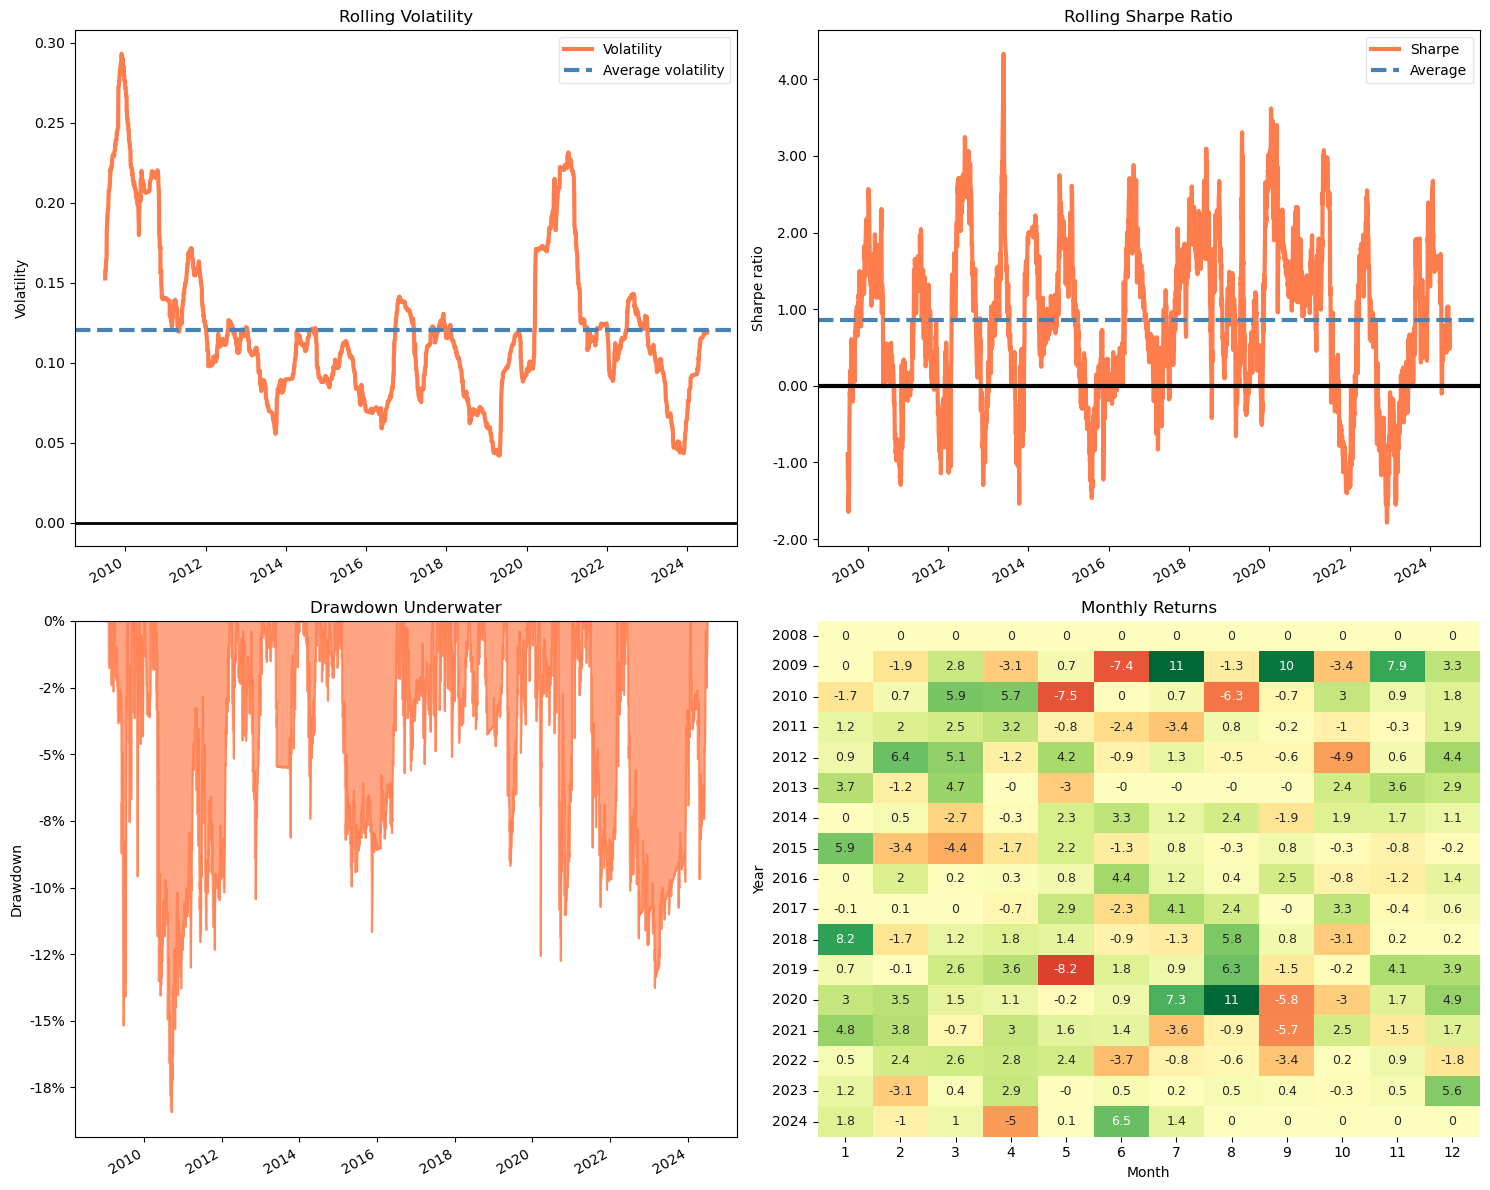

Annual return          0.097750
Cumulative returns     3.236429
Annual volatility      0.129106
Sharpe ratio           0.787145
Calmar ratio           0.530509
Stability              0.970917
Max drawdown          -0.184257
Omega ratio            1.164898
Sortino ratio          1.115456
Skew                  -0.308719
Kurtosis               6.236390
Tail ratio             1.043084
Daily value at risk   -0.015863
dtype: float64


In [13]:
strategy_returns = portfolio_value[251:].pct_change().dropna()
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

plt.sca(axs[0, 0])
pf.plot_rolling_volatility(strategy_returns, ax=axs[0, 0])
axs[0, 0].set_title('Rolling Volatility')

plt.sca(axs[0, 1])
pf.plot_rolling_sharpe(strategy_returns, ax=axs[0, 1])
axs[0, 1].set_title('Rolling Sharpe Ratio')

plt.sca(axs[1, 0])
pf.plot_drawdown_underwater(strategy_returns, ax=axs[1, 0])
axs[1, 0].set_title('Drawdown Underwater')

plt.sca(axs[1, 1])
pf.plot_monthly_returns_heatmap(strategy_returns)
axs[1, 1].set_title('Monthly Returns')

plt.tight_layout()
plt.show()


perf_stats = pf.timeseries.perf_stats(strategy_returns)
print(perf_stats)